# Definitions:

## Import

In [250]:
import pandas as pd
import numpy as np
import os

from imblearn.over_sampling import SMOTE

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.ensemble import RandomForestClassifier

import shap

from keras import layers

print('Importing all done!')

Importing all done!


## Define Functions

### automatic_feature_extraction

In [251]:
def automatic_feature_extraction(data,filepath):
     # Not tested, last time took 1 hour 15 minutes and didnt feel like sittinng through that again. Result is in dataset
        
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Data Cleaning
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName']
    data['5IAL_3_301.BatchName']= data['5IAL_3_301.BatchName'].fillna('No Batch Specified')
    
    
    # Filter out everything that is not a batch
    column_name = '5IAL_3_301.BatchName'
    mask = (data[column_name].str.len() >= 11) & (data[column_name].str.len() <= 12)
    data_selected = data[mask]
    
    Batch_Names=data['5IAL_3_301.BatchName'][mask]
    unique_names=pd.DataFrame(Batch_Names.unique(),columns=['5IAL_3_301.BatchName'])
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create Target
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask] #gets all batches
    search_strings = ['MD112227901'] # [ 14-02-23:'MD112304504', 06-10-22:'MD112227901', 27-06-22'CP7012217502'] -MD112227901
    
    y=unique_names.copy()

    
    y['contains_search_string'] = False
    
    

    #check for name wether its in range of one of the search strin names, if so label as True.
    for i in range(len(y)):
        for j in range(i+1, min(i+21, len(y))):
            if any([search_str == y.loc[j, '5IAL_3_301.BatchName'] for search_str in search_strings]):
                y.loc[i, 'contains_search_string'] = True
                break

    print(np.sum(y['contains_search_string']))
    
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Automatic Feature extraction with tsfresh
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    import tsfresh
    from tsfresh import extract_features
    from tsfresh import select_features
    from tsfresh.utilities.dataframe_functions import impute

    data_selected=data_selected.drop(['5IAL_3_XPV301.36'],axis=1)

    extracted_features = extract_features(data_selected, column_id="5IAL_3_301.BatchName")

    impute(extracted_features)

    y=y.set_index("5IAL_3_301.BatchName")

    features_filtered = select_features(extracted_features, y['contains_search_string'])
    features_filtered.to_csv(filepath)
    
    print('Features saved as csv file to {}'.format(filepath))

    
    return features_filterd

### clean_data

In [252]:
def Clean_data(data, use_PCA):
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    import os
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Data Cleaning
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName']
    data['5IAL_3_301.BatchName']= data['5IAL_3_301.BatchName'].fillna('No Batch Specified')
    
    
    # Filter out everything that is not a batch
    column_name = '5IAL_3_301.BatchName'
    mask = (data[column_name].str.len() >= 11) & (data[column_name].str.len() <= 12)
    data_selected = data[mask]
    data=data_selected

    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Normalise All data
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    Normalise using the z-score
    """
    BatchName=data['5IAL_3_301.BatchName']
    Dates=data['Date']

    data.drop(['5IAL_3_301.BatchName','Date'],axis=1,inplace=True)

    data_norm=pd.DataFrame()
    data_norm_values=pd.DataFrame()
    for col in data:
        zval=(data[col]-np.mean(data[col]))/np.std(data[col])
        data_norm=pd.concat([data_norm,zval],axis=1)
        data_norm_values[col]=[np.mean(data[col]),np.std(data[col])]

    data_norm_values=data_norm_values.rename(index={0:'mean', 1:'std'})
    
    data_norm_values.to_csv(os.getcwd()+'\\temp folder\\normalisation_values=.csv')
        
    data_norm['5IAL_3_301.BatchName']=BatchName
    data['5IAL_3_301.BatchName']=BatchName
    
    
    """ 
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Feature Creation
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    data_norm['frac']=data_norm['5IAL_3_P301.70']/data_norm['5IAL_3_FIT301.61MF']

    
    Batch_duration=data.groupby(data['5IAL_3_301.BatchName']).size()
    Batch_duration=pd.DataFrame(Batch_duration, columns=['Batch_duration'])
    
    #features_2_extract={'5IAL_3_FIT301.61MF': {'mean_n_absolute_max': [{'number_of_maxima': 7}], 'maximum': None, 'absolute_maximum': None, 'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}, {'q': 0.4}], 'cwt_coefficients': [{'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}], 'median': None, 'cid_ce': [{'normalize': False}], 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'root_mean_square': None, 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0}], 'time_reversal_asymmetry_statistic': [{'lag': 2}, {'lag': 3}], 'abs_energy': None, 'absolute_sum_of_changes': None, 'ar_coefficient': [{'coeff': 6, 'k': 10}]}, '5IAL_3_PIT 301.55': {'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}, {'q': 0.4}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'root_mean_square': None, 'cwt_coefficients': [{'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}], 'absolute_maximum': None, 'maximum': None, 'cid_ce': [{'normalize': False}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}], 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'median': None, 'abs_energy': None, 'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}], 'absolute_sum_of_changes': None, 'linear_trend': [{'attr': 'intercept'}], 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}], 'sum_of_reoccurring_values': None, 'ar_coefficient': [{'coeff': 6, 'k': 10}], 'mean_abs_change': None, 'lempel_ziv_complexity': [{'bins': 3}], 'benford_correlation': None, 'fft_coefficient': [{'attr': 'abs', 'coeff': 14}, {'attr': 'abs', 'coeff': 44}], 'number_cwt_peaks': [{'n': 1}], 'variance_larger_than_standard_deviation': None, 'range_count': [{'max': 1, 'min': -1}]}, 'frac': {'quantile': [{'q': 0.7}, {'q': 0.6}, {'q': 0.8}, {'q': 0.9}, {'q': 0.4}, {'q': 0.3}], 'median': None, 'cwt_coefficients': [{'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}], 'number_crossing_m': [{'m': 1}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}], 'c3': [{'lag': 2}, {'lag': 1}, {'lag': 3}], 'mean': None, 'root_mean_square': None, 'linear_trend': [{'attr': 'intercept'}], 'benford_correlation': None, 'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.2}], 'abs_energy': None, 'longest_strike_above_mean': None, 'fft_coefficient': [{'attr': 'abs', 'coeff': 1}, {'attr': 'imag', 'coeff': 1}], 'partial_autocorrelation': [{'lag': 2}, {'lag': 3}], 'count_above_mean': None, 'spkt_welch_density': [{'coeff': 2}], 'index_mass_quantile': [{'q': 0.6}]}, '5IAL_3_TT301.50': {'quantile': [{'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.6}, {'q': 0.7}, {'q': 0.1}, {'q': 0.8}, {'q': 0.9}], 'median': None, 'mean': None, 'sum_of_reoccurring_data_points': None, 'c3': [{'lag': 3}, {'lag': 2}, {'lag': 1}], 'root_mean_square': None, 'sum_values': None, 'fft_coefficient': [{'attr': 'real', 'coeff': 0}, {'attr': 'abs', 'coeff': 0}, {'attr': 'angle', 'coeff': 0}, {'attr': 'abs', 'coeff': 43}, {'attr': 'abs', 'coeff': 45}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 44}, {'attr': 'abs', 'coeff': 39}, {'attr': 'abs', 'coeff': 35}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 42}, {'attr': 'abs', 'coeff': 38}, {'attr': 'abs', 'coeff': 48}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 34}, {'attr': 'abs', 'coeff': 36}, {'attr': 'abs', 'coeff': 47}, {'attr': 'abs', 'coeff': 41}, {'attr': 'abs', 'coeff': 30}, {'attr': 'abs', 'coeff': 50}, {'attr': 'abs', 'coeff': 49}, {'attr': 'abs', 'coeff': 51}, {'attr': 'abs', 'coeff': 46}, {'attr': 'abs', 'coeff': 32}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 31}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 25}, {'attr': 'real', 'coeff': 45}, {'attr': 'abs', 'coeff': 52}, {'attr': 'abs', 'coeff': 27}, {'attr': 'abs', 'coeff': 26}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 23}, {'attr': 'abs', 'coeff': 24}, {'attr': 'abs', 'coeff': 53}, {'attr': 'real', 'coeff': 43}, {'attr': 'abs', 'coeff': 21}, {'attr': 'abs', 'coeff': 20}, {'attr': 'real', 'coeff': 42}, {'attr': 'real', 'coeff': 44}, {'attr': 'real', 'coeff': 49}, {'attr': 'angle', 'coeff': 6}, {'attr': 'real', 'coeff': 51}, {'attr': 'real', 'coeff': 50}, {'attr': 'real', 'coeff': 19}, {'attr': 'abs', 'coeff': 19}, {'attr': 'real', 'coeff': 48}, {'attr': 'abs', 'coeff': 54}, {'attr': 'real', 'coeff': 35}, {'attr': 'real', 'coeff': 52}, {'attr': 'abs', 'coeff': 70}, {'attr': 'real', 'coeff': 40}, {'attr': 'real', 'coeff': 47}, {'attr': 'real', 'coeff': 41}, {'attr': 'abs', 'coeff': 17}, {'attr': 'real', 'coeff': 1}, {'attr': 'real', 'coeff': 46}, {'attr': 'real', 'coeff': 38}, {'attr': 'real', 'coeff': 37}, {'attr': 'abs', 'coeff': 18}, {'attr': 'abs', 'coeff': 59}, {'attr': 'real', 'coeff': 24}], 'abs_energy': None, 'sum_of_reoccurring_values': None, 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'}], 'cwt_coefficients': [{'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'maximum': None, 'absolute_maximum': None, 'range_count': [{'max': 0, 'min': -1000000000000.0}, {'max': 1, 'min': -1}, {'max': 1000000000000.0, 'min': 0}], 'count_above': [{'t': 0}], 'count_below': [{'t': 0}], 'linear_trend': [{'attr': 'intercept'}], 'number_crossing_m': [{'m': 0}, {'m': 1}], 'minimum': None, 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}], 'cid_ce': [{'normalize': False}, {'normalize': True}], 'ar_coefficient': [{'coeff': 0, 'k': 10}, {'coeff': 10, 'k': 10}, {'coeff': 9, 'k': 10}], 'absolute_sum_of_changes': None, 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 4}, {'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 5}], 'partial_autocorrelation': [{'lag': 2}, {'lag': 1}, {'lag': 5}], 'mean_abs_change': None, 'autocorrelation': [{'lag': 1}, {'lag': 2}], 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}], 'skewness': None, 'sample_entropy': None, 'approximate_entropy': [{'m': 2, 'r': 0.3}, {'m': 2, 'r': 0.1}, {'m': 2, 'r': 0.5}], 'spkt_welch_density': [{'coeff': 8}], 'ratio_value_number_to_time_series_length': None, 'ratio_beyond_r_sigma': [{'r': 3}], 'has_duplicate_max': None, 'large_standard_deviation': [{'r': 0.2}], 'symmetry_looking': [{'r': 0.1}], 'fourier_entropy': [{'bins': 100}], 'longest_strike_below_mean': None, 'mean_second_derivative_central': None}, '5IAL_3_QIT301.57': {'number_crossing_m': [{'m': 1}, {'m': 0}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 6}, {'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 5}, {'num_segments': 10, 'segment_focus': 3}, {'num_segments': 10, 'segment_focus': 8}, {'num_segments': 10, 'segment_focus': 4}, {'num_segments': 10, 'segment_focus': 9}, {'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 2}, {'num_segments': 10, 'segment_focus': 1}], 'fft_aggregated': [{'aggtype': 'skew'}, {'aggtype': 'centroid'}], 'large_standard_deviation': [{'r': 0.2}, {'r': 0.30000000000000004}, {'r': 0.25}, {'r': 0.35000000000000003}, {'r': 0.15000000000000002}, {'r': 0.4}], 'ratio_beyond_r_sigma': [{'r': 2.5}, {'r': 3}, {'r': 5}, {'r': 1}, {'r': 6}, {'r': 2}, {'r': 0.5}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.6, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.0}], 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'index_mass_quantile': [{'q': 0.7}, {'q': 0.6}, {'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.1}, {'q': 0.8}], 'skewness': None, 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'agg_linear_trend': [{'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'}], 'augmented_dickey_fuller': [{'attr': 'pvalue', 'autolag': 'AIC'}, {'attr': 'teststat', 'autolag': 'AIC'}, {'attr': 'usedlag', 'autolag': 'AIC'}], 'kurtosis': None, 'cid_ce': [{'normalize': True}, {'normalize': False}], 'fft_coefficient': [{'attr': 'real', 'coeff': 1}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 39}, {'attr': 'imag', 'coeff': 13}, {'attr': 'abs', 'coeff': 38}, {'attr': 'real', 'coeff': 2}, {'attr': 'abs', 'coeff': 43}, {'attr': 'abs', 'coeff': 35}, {'attr': 'abs', 'coeff': 36}, {'attr': 'real', 'coeff': 19}, {'attr': 'abs', 'coeff': 0}, {'attr': 'abs', 'coeff': 41}, {'attr': 'abs', 'coeff': 42}, {'attr': 'abs', 'coeff': 34}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 30}, {'attr': 'real', 'coeff': 20}, {'attr': 'abs', 'coeff': 26}, {'attr': 'abs', 'coeff': 32}, {'attr': 'abs', 'coeff': 25}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 19}, {'attr': 'abs', 'coeff': 31}, {'attr': 'abs', 'coeff': 44}, {'attr': 'abs', 'coeff': 27}, {'attr': 'imag', 'coeff': 12}, {'attr': 'real', 'coeff': 18}, {'attr': 'abs', 'coeff': 23}, {'attr': 'abs', 'coeff': 12}, {'attr': 'abs', 'coeff': 24}, {'attr': 'real', 'coeff': 0}, {'attr': 'abs', 'coeff': 16}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 14}, {'attr': 'abs', 'coeff': 50}, {'attr': 'abs', 'coeff': 8}, {'attr': 'imag', 'coeff': 11}, {'attr': 'abs', 'coeff': 15}, {'attr': 'abs', 'coeff': 18}, {'attr': 'abs', 'coeff': 13}, {'attr': 'real', 'coeff': 23}, {'attr': 'abs', 'coeff': 20}, {'attr': 'real', 'coeff': 21}, {'attr': 'abs', 'coeff': 9}, {'attr': 'angle', 'coeff': 0}, {'attr': 'abs', 'coeff': 49}, {'attr': 'abs', 'coeff': 10}, {'attr': 'abs', 'coeff': 3}, {'attr': 'abs', 'coeff': 5}, {'attr': 'abs', 'coeff': 7}, {'attr': 'abs', 'coeff': 6}, {'attr': 'abs', 'coeff': 21}, {'attr': 'abs', 'coeff': 47}, {'attr': 'abs', 'coeff': 48}, {'attr': 'abs', 'coeff': 2}, {'attr': 'abs', 'coeff': 11}, {'attr': 'abs', 'coeff': 17}, {'attr': 'abs', 'coeff': 4}, {'attr': 'imag', 'coeff': 6}, {'attr': 'real', 'coeff': 15}, {'attr': 'real', 'coeff': 14}, {'attr': 'abs', 'coeff': 51}, {'attr': 'imag', 'coeff': 3}, {'attr': 'imag', 'coeff': 9}, {'attr': 'abs', 'coeff': 45}, {'attr': 'imag', 'coeff': 7}, {'attr': 'real', 'coeff': 4}, {'attr': 'imag', 'coeff': 2}, {'attr': 'imag', 'coeff': 5}, {'attr': 'real', 'coeff': 22}, {'attr': 'real', 'coeff': 17}, {'attr': 'angle', 'coeff': 1}, {'attr': 'real', 'coeff': 16}, {'attr': 'real', 'coeff': 25}, {'attr': 'imag', 'coeff': 10}, {'attr': 'abs', 'coeff': 46}, {'attr': 'real', 'coeff': 3}, {'attr': 'imag', 'coeff': 14}, {'attr': 'real', 'coeff': 24}, {'attr': 'imag', 'coeff': 8}, {'attr': 'imag', 'coeff': 4}, {'attr': 'imag', 'coeff': 1}, {'attr': 'real', 'coeff': 12}, {'attr': 'real', 'coeff': 13}, {'attr': 'abs', 'coeff': 59}, {'attr': 'abs', 'coeff': 53}, {'attr': 'abs', 'coeff': 58}, {'attr': 'real', 'coeff': 5}, {'attr': 'abs', 'coeff': 57}, {'attr': 'angle', 'coeff': 13}, {'attr': 'abs', 'coeff': 52}, {'attr': 'real', 'coeff': 11}, {'attr': 'abs', 'coeff': 56}, {'attr': 'imag', 'coeff': 15}, {'attr': 'abs', 'coeff': 54}, {'attr': 'abs', 'coeff': 63}, {'attr': 'abs', 'coeff': 64}, {'attr': 'abs', 'coeff': 67}, {'attr': 'abs', 'coeff': 61}, {'attr': 'abs', 'coeff': 60}, {'attr': 'abs', 'coeff': 66}, {'attr': 'abs', 'coeff': 62}, {'attr': 'abs', 'coeff': 65}, {'attr': 'real', 'coeff': 26}, {'attr': 'angle', 'coeff': 12}, {'attr': 'real', 'coeff': 28}, {'attr': 'abs', 'coeff': 1}], 'binned_entropy': [{'max_bins': 10}], 'cwt_coefficients': [{'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}], 'agg_autocorrelation': [{'f_agg': 'median', 'maxlag': 40}, {'f_agg': 'var', 'maxlag': 40}, {'f_agg': 'mean', 'maxlag': 40}], 'lempel_ziv_complexity': [{'bins': 5}, {'bins': 10}, {'bins': 3}, {'bins': 2}, {'bins': 100}], 'linear_trend': [{'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'stderr'}, {'attr': 'slope'}, {'attr': 'pvalue'}], 'count_below_mean': None, 'standard_deviation': None, 'variance': None, 'autocorrelation': [{'lag': 9}, {'lag': 3}, {'lag': 8}, {'lag': 4}, {'lag': 2}, {'lag': 7}, {'lag': 5}, {'lag': 6}, {'lag': 1}], 'mean': None, 'mean_abs_change': None, 'c3': [{'lag': 3}, {'lag': 2}, {'lag': 1}], 'friedrich_coefficients': [{'coeff': 1, 'm': 3, 'r': 30}, {'coeff': 0, 'm': 3, 'r': 30}], 'sum_values': None, 'maximum': None, 'longest_strike_below_mean': None, 'absolute_sum_of_changes': None, 'symmetry_looking': [{'r': 0.05}, {'r': 0.15000000000000002}, {'r': 0.1}, {'r': 0.2}], 'max_langevin_fixed_point': [{'m': 3, 'r': 30}], 'root_mean_square': None, 'partial_autocorrelation': [{'lag': 1}, {'lag': 2}], 'ar_coefficient': [{'coeff': 10, 'k': 10}, {'coeff': 0, 'k': 10}], 'abs_energy': None, 'approximate_entropy': [{'m': 2, 'r': 0.5}, {'m': 2, 'r': 0.7}], 'longest_strike_above_mean': None, 'fourier_entropy': [{'bins': 2}, {'bins': 3}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'absolute_maximum': None, 'quantile': [{'q': 0.2}, {'q': 0.3}, {'q': 0.9}, {'q': 0.6}, {'q': 0.7}, {'q': 0.4}, {'q': 0.8}, {'q': 0.1}], 'range_count': [{'max': 1000000000000.0, 'min': 0}], 'count_above_mean': None, 'count_below': [{'t': 0}], 'count_above': [{'t': 0}], 'ratio_value_number_to_time_series_length': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'matrix_profile': [{'feature': '75', 'threshold': 0.98}, {'feature': 'mean', 'threshold': 0.98}, {'feature': '25', 'threshold': 0.98}], 'spkt_welch_density': [{'coeff': 5}, {'coeff': 8}], 'median': None, 'percentage_of_reoccurring_values_to_all_values': None}, '5IAL_3_QIT301.52': {'maximum': None, 'approximate_entropy': [{'m': 2, 'r': 0.1}, {'m': 2, 'r': 0.3}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'}], 'cwt_coefficients': [{'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}], 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'skewness': None, 'linear_trend': [{'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'rvalue'}, {'attr': 'pvalue'}], 'quantile': [{'q': 0.9}], 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 3}, {'lag': 2}], 'fft_coefficient': [{'attr': 'real', 'coeff': 1}, {'attr': 'imag', 'coeff': 1}, {'attr': 'real', 'coeff': 19}, {'attr': 'real', 'coeff': 18}, {'attr': 'imag', 'coeff': 2}, {'attr': 'imag', 'coeff': 3}, {'attr': 'real', 'coeff': 20}, {'attr': 'imag', 'coeff': 5}, {'attr': 'imag', 'coeff': 6}, {'attr': 'real', 'coeff': 22}, {'attr': 'abs', 'coeff': 6}, {'attr': 'real', 'coeff': 23}, {'attr': 'real', 'coeff': 21}, {'attr': 'imag', 'coeff': 4}, {'attr': 'real', 'coeff': 17}, {'attr': 'abs', 'coeff': 7}, {'attr': 'angle', 'coeff': 0}, {'attr': 'abs', 'coeff': 8}, {'attr': 'imag', 'coeff': 7}, {'attr': 'imag', 'coeff': 8}, {'attr': 'imag', 'coeff': 9}, {'attr': 'real', 'coeff': 16}, {'attr': 'imag', 'coeff': 10}, {'attr': 'real', 'coeff': 0}, {'attr': 'angle', 'coeff': 1}, {'attr': 'real', 'coeff': 8}, {'attr': 'real', 'coeff': 6}, {'attr': 'real', 'coeff': 15}, {'attr': 'abs', 'coeff': 3}, {'attr': 'real', 'coeff': 7}, {'attr': 'abs', 'coeff': 18}, {'attr': 'real', 'coeff': 24}, {'attr': 'abs', 'coeff': 5}, {'attr': 'abs', 'coeff': 1}, {'attr': 'real', 'coeff': 2}, {'attr': 'abs', 'coeff': 17}, {'attr': 'abs', 'coeff': 9}, {'attr': 'abs', 'coeff': 4}, {'attr': 'abs', 'coeff': 12}, {'attr': 'real', 'coeff': 25}, {'attr': 'abs', 'coeff': 13}, {'attr': 'abs', 'coeff': 2}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}], 'longest_strike_below_mean': None, 'index_mass_quantile': [{'q': 0.6}, {'q': 0.4}, {'q': 0.3}, {'q': 0.7}, {'q': 0.2}, {'q': 0.8}, {'q': 0.9}], 'sample_entropy': None, 'count_below_mean': None, 'percentage_of_reoccurring_values_to_all_values': None, 'matrix_profile': [{'feature': 'median', 'threshold': 0.98}, {'feature': '75', 'threshold': 0.98}, {'feature': 'max', 'threshold': 0.98}, {'feature': 'mean', 'threshold': 0.98}, {'feature': 'min', 'threshold': 0.98}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'permutation_entropy': [{'dimension': 7, 'tau': 1}, {'dimension': 6, 'tau': 1}, {'dimension': 5, 'tau': 1}, {'dimension': 4, 'tau': 1}, {'dimension': 3, 'tau': 1}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 9}, {'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 6}, {'num_segments': 10, 'segment_focus': 8}], 'fourier_entropy': [{'bins': 100}, {'bins': 5}], 'cid_ce': [{'normalize': False}], 'count_above_mean': None, 'absolute_sum_of_changes': None, 'number_crossing_m': [{'m': 1}], 'minimum': None, 'range_count': [{'max': 0, 'min': -1000000000000.0}], 'standard_deviation': None, 'variance': None, 'number_peaks': [{'n': 1}], 'root_mean_square': None, 'ratio_beyond_r_sigma': [{'r': 1.5}, {'r': 2}, {'r': 5}], 'partial_autocorrelation': [{'lag': 3}], 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'mean': None, 'longest_strike_above_mean': None, 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}], 'autocorrelation': [{'lag': 9}, {'lag': 8}, {'lag': 7}], 'abs_energy': None, 'sum_values': None, 'benford_correlation': None, 'kurtosis': None, 'lempel_ziv_complexity': [{'bins': 3}], 'variation_coefficient': None}, '5IAL_3_FIT301.61VF': {'quantile': [{'q': 0.7}, {'q': 0.8}, {'q': 0.6}, {'q': 0.9}, {'q': 0.4}], 'cwt_coefficients': [{'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}], 'root_mean_square': None, 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 2}, {'num_segments': 10, 'segment_focus': 1}, {'num_segments': 10, 'segment_focus': 3}, {'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 0}], 'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}], 'median': None, 'maximum': None, 'index_mass_quantile': [{'q': 0.7}, {'q': 0.6}, {'q': 0.1}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.8}], 'first_location_of_maximum': None, 'last_location_of_maximum': None, 'cid_ce': [{'normalize': False}]}, '5IAL_3_FIT301.61D': {'minimum': None, 'quantile': [{'q': 0.4}, {'q': 0.3}, {'q': 0.6}, {'q': 0.7}, {'q': 0.8}, {'q': 0.2}], 'median': None, 'cid_ce': [{'normalize': False}], 'cwt_coefficients': [{'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}], 'has_duplicate_min': None}, '5IAL_3_WY301.54': {'last_location_of_minimum': None, 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.2, 'ql': 0.0}], 'cwt_coefficients': [{'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 1}], 'cid_ce': [{'normalize': False}], 'benford_correlation': None, 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}], 'percentage_of_reoccurring_values_to_all_values': None, 'matrix_profile': [{'feature': 'max', 'threshold': 0.98}], 'minimum': None, 'large_standard_deviation': [{'r': 0.30000000000000004}], 'has_duplicate_min': None, 'ar_coefficient': [{'coeff': 10, 'k': 10}], 'linear_trend': [{'attr': 'intercept'}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}]}, '5IAL_3_LIT301.54': {'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 1}], 'cid_ce': [{'normalize': False}, {'normalize': True}], 'ar_coefficient': [{'coeff': 6, 'k': 10}, {'coeff': 7, 'k': 10}, {'coeff': 10, 'k': 10}, {'coeff': 5, 'k': 10}], 'approximate_entropy': [{'m': 2, 'r': 0.9}, {'m': 2, 'r': 0.7}], 'cwt_coefficients': [{'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.2, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0}], 'index_mass_quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}], 'matrix_profile': [{'feature': 'max', 'threshold': 0.98}, {'feature': 'mean', 'threshold': 0.98}, {'feature': 'min', 'threshold': 0.98}], 'kurtosis': None, 'partial_autocorrelation': [{'lag': 4}], 'fft_coefficient': [{'attr': 'imag', 'coeff': 18}]}, '5IAL_3_PIT301.60': {'large_standard_deviation': [{'r': 0.55}, {'r': 0.65}, {'r': 0.7000000000000001}, {'r': 0.9500000000000001}, {'r': 0.6000000000000001}, {'r': 0.45}, {'r': 0.8500000000000001}, {'r': 0.8}, {'r': 0.75}, {'r': 0.5}, {'r': 0.9}, {'r': 0.4}, {'r': 0.35000000000000003}, {'r': 0.30000000000000004}, {'r': 0.25}, {'r': 0.2}], 'absolute_maximum': None, 'maximum': None, 'fft_coefficient': [{'attr': 'abs', 'coeff': 15}, {'attr': 'imag', 'coeff': 4}, {'attr': 'abs', 'coeff': 11}, {'attr': 'abs', 'coeff': 7}, {'attr': 'imag', 'coeff': 2}, {'attr': 'abs', 'coeff': 17}, {'attr': 'abs', 'coeff': 10}, {'attr': 'angle', 'coeff': 2}, {'attr': 'abs', 'coeff': 2}, {'attr': 'abs', 'coeff': 5}, {'attr': 'angle', 'coeff': 9}, {'attr': 'imag', 'coeff': 6}, {'attr': 'angle', 'coeff': 6}, {'attr': 'angle', 'coeff': 4}, {'attr': 'angle', 'coeff': 10}, {'attr': 'abs', 'coeff': 4}, {'attr': 'real', 'coeff': 2}, {'attr': 'angle', 'coeff': 1}, {'attr': 'abs', 'coeff': 6}, {'attr': 'abs', 'coeff': 3}, {'attr': 'angle', 'coeff': 11}, {'attr': 'abs', 'coeff': 14}, {'attr': 'abs', 'coeff': 8}, {'attr': 'imag', 'coeff': 9}, {'attr': 'abs', 'coeff': 25}, {'attr': 'imag', 'coeff': 1}, {'attr': 'abs', 'coeff': 13}, {'attr': 'abs', 'coeff': 23}, {'attr': 'imag', 'coeff': 3}, {'attr': 'abs', 'coeff': 31}, {'attr': 'abs', 'coeff': 12}, {'attr': 'imag', 'coeff': 5}, {'attr': 'imag', 'coeff': 7}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 27}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 16}, {'attr': 'abs', 'coeff': 19}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 20}, {'attr': 'abs', 'coeff': 9}, {'attr': 'abs', 'coeff': 1}, {'attr': 'abs', 'coeff': 24}, {'attr': 'abs', 'coeff': 50}, {'attr': 'abs', 'coeff': 35}, {'attr': 'imag', 'coeff': 8}, {'attr': 'imag', 'coeff': 10}, {'attr': 'angle', 'coeff': 7}, {'attr': 'abs', 'coeff': 36}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 32}, {'attr': 'abs', 'coeff': 21}, {'attr': 'imag', 'coeff': 11}, {'attr': 'angle', 'coeff': 13}, {'attr': 'abs', 'coeff': 18}, {'attr': 'abs', 'coeff': 42}, {'attr': 'abs', 'coeff': 34}, {'attr': 'angle', 'coeff': 5}, {'attr': 'real', 'coeff': 1}, {'attr': 'abs', 'coeff': 51}, {'attr': 'abs', 'coeff': 30}, {'attr': 'abs', 'coeff': 26}, {'attr': 'abs', 'coeff': 41}, {'attr': 'angle', 'coeff': 12}, {'attr': 'imag', 'coeff': 12}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 45}, {'attr': 'real', 'coeff': 4}, {'attr': 'abs', 'coeff': 43}, {'attr': 'abs', 'coeff': 38}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 39}, {'attr': 'imag', 'coeff': 13}, {'attr': 'abs', 'coeff': 44}, {'attr': 'abs', 'coeff': 53}, {'attr': 'abs', 'coeff': 52}, {'attr': 'real', 'coeff': 3}, {'attr': 'angle', 'coeff': 15}, {'attr': 'real', 'coeff': 6}, {'attr': 'abs', 'coeff': 49}, {'attr': 'abs', 'coeff': 48}, {'attr': 'abs', 'coeff': 47}, {'attr': 'abs', 'coeff': 46}, {'attr': 'real', 'coeff': 5}, {'attr': 'angle', 'coeff': 8}, {'attr': 'real', 'coeff': 7}, {'attr': 'angle', 'coeff': 17}, {'attr': 'abs', 'coeff': 59}, {'attr': 'imag', 'coeff': 14}, {'attr': 'abs', 'coeff': 63}, {'attr': 'abs', 'coeff': 58}, {'attr': 'abs', 'coeff': 57}, {'attr': 'abs', 'coeff': 61}, {'attr': 'abs', 'coeff': 54}, {'attr': 'abs', 'coeff': 60}, {'attr': 'angle', 'coeff': 16}, {'attr': 'abs', 'coeff': 62}, {'attr': 'angle', 'coeff': 14}, {'attr': 'angle', 'coeff': 3}, {'attr': 'abs', 'coeff': 55}, {'attr': 'imag', 'coeff': 15}, {'attr': 'abs', 'coeff': 56}, {'attr': 'abs', 'coeff': 64}, {'attr': 'real', 'coeff': 50}, {'attr': 'abs', 'coeff': 67}, {'attr': 'angle', 'coeff': 18}, {'attr': 'abs', 'coeff': 70}, {'attr': 'abs', 'coeff': 69}, {'attr': 'abs', 'coeff': 66}, {'attr': 'abs', 'coeff': 68}, {'attr': 'abs', 'coeff': 65}, {'attr': 'imag', 'coeff': 16}, {'attr': 'imag', 'coeff': 17}], 'number_crossing_m': [{'m': 1}], 'symmetry_looking': [{'r': 0.65}, {'r': 0.45}, {'r': 0.5}, {'r': 0.55}, {'r': 0.4}, {'r': 0.6000000000000001}, {'r': 0.35000000000000003}, {'r': 0.8}, {'r': 0.8500000000000001}, {'r': 0.7000000000000001}, {'r': 0.30000000000000004}, {'r': 0.9}, {'r': 0.9500000000000001}, {'r': 0.75}, {'r': 0.25}, {'r': 0.2}, {'r': 0.15000000000000002}, {'r': 0.1}, {'r': 0.05}], 'cid_ce': [{'normalize': False}, {'normalize': True}], 'absolute_sum_of_changes': None, 'ar_coefficient': [{'coeff': 1, 'k': 10}, {'coeff': 0, 'k': 10}, {'coeff': 10, 'k': 10}, {'coeff': 2, 'k': 10}, {'coeff': 9, 'k': 10}, {'coeff': 3, 'k': 10}, {'coeff': 4, 'k': 10}, {'coeff': 8, 'k': 10}, {'coeff': 5, 'k': 10}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'}], 'cwt_coefficients': [{'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}], 'spkt_welch_density': [{'coeff': 8}, {'coeff': 5}, {'coeff': 2}], 'permutation_entropy': [{'dimension': 7, 'tau': 1}, {'dimension': 6, 'tau': 1}, {'dimension': 5, 'tau': 1}, {'dimension': 4, 'tau': 1}, {'dimension': 3, 'tau': 1}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'c3': [{'lag': 1}, {'lag': 3}, {'lag': 2}], 'agg_autocorrelation': [{'f_agg': 'var', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}, {'f_agg': 'mean', 'maxlag': 40}], 'binned_entropy': [{'max_bins': 10}], 'ratio_beyond_r_sigma': [{'r': 1.5}, {'r': 1}, {'r': 2}, {'r': 2.5}, {'r': 3}, {'r': 0.5}, {'r': 5}], 'approximate_entropy': [{'m': 2, 'r': 0.5}, {'m': 2, 'r': 0.7}, {'m': 2, 'r': 0.9}, {'m': 2, 'r': 0.3}, {'m': 2, 'r': 0.1}], 'linear_trend': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}], 'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}, {'lag': 1}], 'benford_correlation': None, 'root_mean_square': None, 'index_mass_quantile': [{'q': 0.2}, {'q': 0.6}, {'q': 0.1}, {'q': 0.4}, {'q': 0.3}, {'q': 0.7}, {'q': 0.8}], 'change_quantiles': [{'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 4}, {'num_segments': 10, 'segment_focus': 5}, {'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 6}, {'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 8}, {'num_segments': 10, 'segment_focus': 3}, {'num_segments': 10, 'segment_focus': 9}, {'num_segments': 10, 'segment_focus': 2}, {'num_segments': 10, 'segment_focus': 1}], 'mean_abs_change': None, 'fft_aggregated': [{'aggtype': 'centroid'}, {'aggtype': 'variance'}], 'standard_deviation': None, 'variance': None, 'first_location_of_maximum': None, 'variation_coefficient': None, 'sum_of_reoccurring_values': None, 'mean': None, 'partial_autocorrelation': [{'lag': 1}], 'ratio_value_number_to_time_series_length': None, 'kurtosis': None, 'last_location_of_maximum': None, 'skewness': None, 'mean_second_derivative_central': None, 'lempel_ziv_complexity': [{'bins': 5}, {'bins': 10}, {'bins': 100}, {'bins': 3}, {'bins': 2}], 'number_cwt_peaks': [{'n': 1}]}, '5IAL_3_PIT301.63': {'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': False, 'qh': 0.6, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}], 'agg_linear_trend': [{'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'}], 'lempel_ziv_complexity': [{'bins': 100}, {'bins': 10}, {'bins': 5}, {'bins': 3}], 'ratio_value_number_to_time_series_length': None, 'fft_coefficient': [{'attr': 'real', 'coeff': 26}, {'attr': 'real', 'coeff': 28}, {'attr': 'imag', 'coeff': 7}, {'attr': 'imag', 'coeff': 2}, {'attr': 'imag', 'coeff': 5}, {'attr': 'real', 'coeff': 50}, {'attr': 'imag', 'coeff': 9}, {'attr': 'imag', 'coeff': 11}, {'attr': 'real', 'coeff': 40}, {'attr': 'imag', 'coeff': 1}, {'attr': 'abs', 'coeff': 11}, {'attr': 'angle', 'coeff': 9}, {'attr': 'abs', 'coeff': 5}, {'attr': 'real', 'coeff': 31}, {'attr': 'abs', 'coeff': 17}, {'attr': 'abs', 'coeff': 45}, {'attr': 'angle', 'coeff': 7}, {'attr': 'real', 'coeff': 39}, {'attr': 'angle', 'coeff': 5}, {'attr': 'abs', 'coeff': 47}], 'linear_trend': [{'attr': 'slope'}, {'attr': 'rvalue'}], 'mean_change': None, 'binned_entropy': [{'max_bins': 10}], 'last_location_of_maximum': None, 'permutation_entropy': [{'dimension': 6, 'tau': 1}, {'dimension': 7, 'tau': 1}, {'dimension': 5, 'tau': 1}, {'dimension': 4, 'tau': 1}, {'dimension': 3, 'tau': 1}], 'number_cwt_peaks': [{'n': 5}, {'n': 1}], 'standard_deviation': None, 'variance': None, 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 1}], 'first_location_of_minimum': None, 'variation_coefficient': None, 'sample_entropy': None}, '5IAL_3_R301.71': {'cwt_coefficients': [{'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}], 'number_cwt_peaks': [{'n': 5}], 'mean_n_absolute_max': [{'number_of_maxima': 7}]}, '5IAL_3_XPV301.13': {'minimum': None, 'ar_coefficient': [{'coeff': 6, 'k': 10}], 'sum_of_reoccurring_values': None, 'mean_n_absolute_max': [{'number_of_maxima': 7}]}, '5IAL_3_XPV301.42': {'fft_coefficient': [{'attr': 'angle', 'coeff': 43}, {'attr': 'imag', 'coeff': 43}]}, '5IAL_3_LSH301.56': {'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}]}, '5IAL_3_LSL301.64': {'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}], 'partial_autocorrelation': [{'lag': 9}, {'lag': 8}, {'lag': 7}, {'lag': 6}, {'lag': 5}, {'lag': 4}, {'lag': 3}, {'lag': 2}, {'lag': 1}], 'fft_aggregated': [{'aggtype': 'skew'}, {'aggtype': 'kurtosis'}], 'augmented_dickey_fuller': [{'attr': 'pvalue', 'autolag': 'AIC'}, {'attr': 'teststat', 'autolag': 'AIC'}], 'linear_trend': [{'attr': 'rvalue'}, {'attr': 'slope'}, {'attr': 'pvalue'}], 'autocorrelation': [{'lag': 1}, {'lag': 2}, {'lag': 3}, {'lag': 4}, {'lag': 5}, {'lag': 6}, {'lag': 7}, {'lag': 8}, {'lag': 9}], 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}, {'f_agg': 'var', 'maxlag': 40}], 'count_above': [{'t': 0}], 'approximate_entropy': [{'m': 2, 'r': 0.3}, {'m': 2, 'r': 0.1}, {'m': 2, 'r': 0.9}, {'m': 2, 'r': 0.7}, {'m': 2, 'r': 0.5}], 'first_location_of_maximum': None, 'benford_correlation': None, 'ratio_beyond_r_sigma': [{'r': 1}, {'r': 1.5}], 'change_quantiles': [{'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2}], 'range_count': [{'max': 1000000000000.0, 'min': 0}], 'permutation_entropy': [{'dimension': 4, 'tau': 1}, {'dimension': 3, 'tau': 1}, {'dimension': 6, 'tau': 1}, {'dimension': 7, 'tau': 1}, {'dimension': 5, 'tau': 1}], 'mean_abs_change': None, 'binned_entropy': [{'max_bins': 10}], 'count_below': [{'t': 0}], 'skewness': None, 'cid_ce': [{'normalize': True}], 'kurtosis': None, 'last_location_of_maximum': None}, '5IAL_3_LSL301.53': {'fft_coefficient': [{'attr': 'angle', 'coeff': 58}, {'attr': 'angle', 'coeff': 55}], 'cwt_coefficients': [{'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}]}, '5IAL_3_P301.70': {'mean_n_absolute_max': [{'number_of_maxima': 7}], 'minimum': None, 'has_duplicate_max': None}, '5IAL_3_LSL301.51': {'cwt_coefficients': [{'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}]}}
    features_2_extract={'5IAL_3_QIT301.57': {'ratio_beyond_r_sigma': [{'r': 6}, {'r': 5}, {'r': 3}, {'r': 2.5}, {'r': 0.5}, {'r': 1}], 'large_standard_deviation': [{'r': 0.2}, {'r': 0.25}, {'r': 0.30000000000000004}, {'r': 0.15000000000000002}, {'r': 0.35000000000000003}], 'change_quantiles': [{'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.4}, {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.4}], 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'skewness': None, 'cwt_coefficients': [{'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)}], 'index_mass_quantile': [{'q': 0.2}, {'q': 0.3}, {'q': 0.1}, {'q': 0.4}, {'q': 0.6}], 'binned_entropy': [{'max_bins': 10}], 'variation_coefficient': None, 'kurtosis': None, 'autocorrelation': [{'lag': 4}, {'lag': 9}, {'lag': 3}, {'lag': 8}, {'lag': 5}, {'lag': 7}, {'lag': 6}, {'lag': 2}, {'lag': 1}], 'agg_linear_trend': [{'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}], 'fft_aggregated': [{'aggtype': 'skew'}, {'aggtype': 'centroid'}], 'fft_coefficient': [{'attr': 'imag', 'coeff': 12}, {'attr': 'real', 'coeff': 18}, {'attr': 'real', 'coeff': 2}, {'attr': 'real', 'coeff': 19}, {'attr': 'real', 'coeff': 4}, {'attr': 'imag', 'coeff': 11}, {'attr': 'imag', 'coeff': 7}, {'attr': 'imag', 'coeff': 6}, {'attr': 'abs', 'coeff': 16}, {'attr': 'real', 'coeff': 23}, {'attr': 'abs', 'coeff': 8}, {'attr': 'real', 'coeff': 1}, {'attr': 'real', 'coeff': 14}, {'attr': 'abs', 'coeff': 26}, {'attr': 'imag', 'coeff': 13}, {'attr': 'real', 'coeff': 3}, {'attr': 'abs', 'coeff': 17}, {'attr': 'abs', 'coeff': 15}, {'attr': 'abs', 'coeff': 19}, {'attr': 'abs', 'coeff': 12}, {'attr': 'abs', 'coeff': 10}, {'attr': 'abs', 'coeff': 5}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 18}, {'attr': 'abs', 'coeff': 13}, {'attr': 'imag', 'coeff': 9}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 9}, {'attr': 'abs', 'coeff': 25}, {'attr': 'abs', 'coeff': 23}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 27}, {'attr': 'real', 'coeff': 22}, {'attr': 'abs', 'coeff': 14}, {'attr': 'abs', 'coeff': 20}, {'attr': 'real', 'coeff': 15}, {'attr': 'abs', 'coeff': 50}, {'attr': 'abs', 'coeff': 30}, {'attr': 'abs', 'coeff': 36}, {'attr': 'imag', 'coeff': 8}, {'attr': 'abs', 'coeff': 7}, {'attr': 'abs', 'coeff': 31}, {'attr': 'real', 'coeff': 12}, {'attr': 'abs', 'coeff': 35}, {'attr': 'real', 'coeff': 13}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 24}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 39}, {'attr': 'abs', 'coeff': 34}, {'attr': 'abs', 'coeff': 32}, {'attr': 'real', 'coeff': 16}, {'attr': 'abs', 'coeff': 38}, {'attr': 'abs', 'coeff': 6}, {'attr': 'abs', 'coeff': 21}, {'attr': 'abs', 'coeff': 11}, {'attr': 'imag', 'coeff': 5}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 6}, {'num_segments': 10, 'segment_focus': 8}, {'num_segments': 10, 'segment_focus': 5}], 'absolute_maximum': None, 'maximum': None, 'symmetry_looking': [{'r': 0.05}], 'lempel_ziv_complexity': [{'bins': 10}, {'bins': 5}], 'partial_autocorrelation': [{'lag': 2}, {'lag': 1}], 'max_langevin_fixed_point': [{'m': 3, 'r': 30}], 'cid_ce': [{'normalize': True}, {'normalize': False}], 'friedrich_coefficients': [{'coeff': 3, 'm': 3, 'r': 30}, {'coeff': 2, 'm': 3, 'r': 30}], 'absolute_sum_of_changes': None, 'agg_autocorrelation': [{'f_agg': 'var', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}, {'f_agg': 'mean', 'maxlag': 40}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'mean_abs_change': None, 'standard_deviation': None, 'variance': None, 'ar_coefficient': [{'coeff': 10, 'k': 10}, {'coeff': 0, 'k': 10}], 'augmented_dickey_fuller': [{'attr': 'pvalue', 'autolag': 'AIC'}, {'attr': 'teststat', 'autolag': 'AIC'}], 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'linear_trend': [{'attr': 'stderr'}, {'attr': 'intercept'}], 'root_mean_square': None, 'count_below_mean': None, 'abs_energy': None, 'approximate_entropy': [{'m': 2, 'r': 0.5}], 'longest_strike_below_mean': None, 'mean': None}, '5IAL_3_FIT301.61MF': {'mean_n_absolute_max': [{'number_of_maxima': 7}], 'absolute_maximum': None, 'maximum': None, 'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}], 'cwt_coefficients': [{'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}], 'median': None}, '5IAL_3_PIT301.63': {'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'}], 'cwt_coefficients': [{'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}], 'root_mean_square': None, 'mean': None, 'quantile': [{'q': 0.6}, {'q': 0.9}, {'q': 0.8}, {'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.7}, {'q': 0.1}], 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 'maximum': None, 'absolute_maximum': None, 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'median': None, 'linear_trend': [{'attr': 'intercept'}], 'minimum': None, 'sum_of_reoccurring_values': None, 'fft_coefficient': [{'attr': 'real', 'coeff': 50}, {'attr': 'real', 'coeff': 28}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}]}, '5IAL_3_PIT 301.55': {'maximum': None, 'absolute_maximum': None, 'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'cid_ce': [{'normalize': False}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}], 'cwt_coefficients': [{'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}], 'absolute_sum_of_changes': None, 'number_crossing_m': [{'m': 1}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}], 'time_reversal_asymmetry_statistic': [{'lag': 2}, {'lag': 3}]}, '5IAL_3_QIT301.52': {'absolute_maximum': None, 'maximum': None, 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'cwt_coefficients': [{'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}], 'approximate_entropy': [{'m': 2, 'r': 0.1}], 'skewness': None, 'index_mass_quantile': [{'q': 0.3}, {'q': 0.1}, {'q': 0.2}, {'q': 0.4}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}, {'num_segments': 10, 'segment_focus': 7}, {'num_segments': 10, 'segment_focus': 8}, {'num_segments': 10, 'segment_focus': 6}], 'sample_entropy': None, 'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}], 'percentage_of_reoccurring_values_to_all_values': None, 'matrix_profile': [{'feature': '75', 'threshold': 0.98}, {'feature': 'median', 'threshold': 0.98}, {'feature': 'mean', 'threshold': 0.98}, {'feature': 'max', 'threshold': 0.98}], 'permutation_entropy': [{'dimension': 7, 'tau': 1}, {'dimension': 6, 'tau': 1}, {'dimension': 5, 'tau': 1}, {'dimension': 4, 'tau': 1}], 'linear_trend': [{'attr': 'intercept'}, {'attr': 'rvalue'}, {'attr': 'slope'}], 'fft_coefficient': [{'attr': 'real', 'coeff': 1}, {'attr': 'imag', 'coeff': 1}, {'attr': 'imag', 'coeff': 6}], 'quantile': [{'q': 0.9}], 'longest_strike_below_mean': None, 'count_below_mean': None, 'variance_larger_than_standard_deviation': None}, '5IAL_3_TT301.50': {'fft_coefficient': [{'attr': 'abs', 'coeff': 39}, {'attr': 'abs', 'coeff': 44}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 45}, {'attr': 'abs', 'coeff': 34}, {'attr': 'abs', 'coeff': 43}, {'attr': 'abs', 'coeff': 49}, {'attr': 'abs', 'coeff': 35}, {'attr': 'abs', 'coeff': 36}, {'attr': 'abs', 'coeff': 38}, {'attr': 'abs', 'coeff': 41}, {'attr': 'abs', 'coeff': 47}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 51}, {'attr': 'abs', 'coeff': 50}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 42}, {'attr': 'abs', 'coeff': 48}, {'attr': 'abs', 'coeff': 46}, {'attr': 'abs', 'coeff': 29}, {'attr': 'real', 'coeff': 49}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 32}, {'attr': 'imag', 'coeff': 12}, {'attr': 'abs', 'coeff': 30}], 'cwt_coefficients': [{'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}], 'quantile': [{'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.6}, {'q': 0.7}, {'q': 0.1}, {'q': 0.8}], 'median': None, 'partial_autocorrelation': [{'lag': 2}], 'mean': None, 'root_mean_square': None, 'c3': [{'lag': 1}, {'lag': 3}, {'lag': 2}], 'fft_aggregated': [{'aggtype': 'kurtosis'}, {'aggtype': 'skew'}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}], 'ar_coefficient': [{'coeff': 10, 'k': 10}]}, '5IAL_3_PIT301.60': {'number_crossing_m': [{'m': 0}], 'absolute_maximum': None, 'absolute_sum_of_changes': None, 'cid_ce': [{'normalize': False}, {'normalize': True}], 'maximum': None, 'symmetry_looking': [{'r': 0.55}, {'r': 0.65}, {'r': 0.6000000000000001}, {'r': 0.25}, {'r': 0.5}, {'r': 0.45}, {'r': 0.4}, {'r': 0.8500000000000001}, {'r': 0.9500000000000001}, {'r': 0.35000000000000003}, {'r': 0.9}, {'r': 0.8}, {'r': 0.30000000000000004}, {'r': 0.7000000000000001}, {'r': 0.75}, {'r': 0.2}, {'r': 0.15000000000000002}, {'r': 0.1}, {'r': 0.05}], 'large_standard_deviation': [{'r': 0.05}], 'approximate_entropy': [{'m': 2, 'r': 0.9}, {'m': 2, 'r': 0.5}, {'m': 2, 'r': 0.3}, {'m': 2, 'r': 0.1}, {'m': 2, 'r': 0.7}], 'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'}, {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'}], 'spkt_welch_density': [{'coeff': 8}, {'coeff': 5}, {'coeff': 2}], 'first_location_of_maximum': None, 'fft_coefficient': [{'attr': 'angle', 'coeff': 2}, {'attr': 'angle', 'coeff': 1}, {'attr': 'angle', 'coeff': 4}, {'attr': 'angle', 'coeff': 3}, {'attr': 'abs', 'coeff': 51}, {'attr': 'imag', 'coeff': 2}, {'attr': 'angle', 'coeff': 5}, {'attr': 'imag', 'coeff': 1}, {'attr': 'imag', 'coeff': 4}, {'attr': 'abs', 'coeff': 50}, {'attr': 'imag', 'coeff': 3}, {'attr': 'angle', 'coeff': 6}, {'attr': 'abs', 'coeff': 3}, {'attr': 'abs', 'coeff': 4}, {'attr': 'abs', 'coeff': 5}, {'attr': 'abs', 'coeff': 7}, {'attr': 'abs', 'coeff': 0}, {'attr': 'abs', 'coeff': 6}, {'attr': 'abs', 'coeff': 8}, {'attr': 'abs', 'coeff': 2}, {'attr': 'angle', 'coeff': 7}, {'attr': 'abs', 'coeff': 9}, {'attr': 'abs', 'coeff': 10}, {'attr': 'abs', 'coeff': 1}, {'attr': 'imag', 'coeff': 5}, {'attr': 'abs', 'coeff': 11}, {'attr': 'abs', 'coeff': 43}, {'attr': 'abs', 'coeff': 12}, {'attr': 'angle', 'coeff': 8}, {'attr': 'abs', 'coeff': 27}, {'attr': 'abs', 'coeff': 49}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 36}, {'attr': 'abs', 'coeff': 42}, {'attr': 'angle', 'coeff': 9}, {'attr': 'abs', 'coeff': 26}, {'attr': 'angle', 'coeff': 10}, {'attr': 'imag', 'coeff': 6}, {'attr': 'abs', 'coeff': 25}, {'attr': 'abs', 'coeff': 13}, {'attr': 'angle', 'coeff': 11}, {'attr': 'abs', 'coeff': 24}, {'attr': 'abs', 'coeff': 40}, {'attr': 'abs', 'coeff': 23}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 14}, {'attr': 'abs', 'coeff': 41}, {'attr': 'abs', 'coeff': 37}, {'attr': 'abs', 'coeff': 30}, {'attr': 'abs', 'coeff': 15}, {'attr': 'angle', 'coeff': 12}, {'attr': 'abs', 'coeff': 16}, {'attr': 'abs', 'coeff': 38}, {'attr': 'abs', 'coeff': 48}, {'attr': 'imag', 'coeff': 7}, {'attr': 'abs', 'coeff': 20}, {'attr': 'abs', 'coeff': 31}, {'attr': 'abs', 'coeff': 39}, {'attr': 'abs', 'coeff': 35}, {'attr': 'abs', 'coeff': 32}, {'attr': 'abs', 'coeff': 21}, {'attr': 'abs', 'coeff': 19}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 33}, {'attr': 'abs', 'coeff': 17}, {'attr': 'imag', 'coeff': 8}, {'attr': 'abs', 'coeff': 18}, {'attr': 'abs', 'coeff': 44}, {'attr': 'angle', 'coeff': 13}, {'attr': 'imag', 'coeff': 9}, {'attr': 'abs', 'coeff': 34}, {'attr': 'abs', 'coeff': 47}, {'attr': 'imag', 'coeff': 10}, {'attr': 'real', 'coeff': 0}], 'permutation_entropy': [{'dimension': 7, 'tau': 1}, {'dimension': 6, 'tau': 1}, {'dimension': 5, 'tau': 1}, {'dimension': 3, 'tau': 1}, {'dimension': 4, 'tau': 1}], 'change_quantiles': [{'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4}, {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.8}], 'mean_abs_change': None, 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'abs_energy': None, 'cwt_coefficients': [{'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}], 'count_above_mean': None, 'longest_strike_above_mean': None, 'root_mean_square': None, 'binned_entropy': [{'max_bins': 10}], 'standard_deviation': None, 'variance': None, 'ratio_beyond_r_sigma': [{'r': 0.5}, {'r': 1}, {'r': 1.5}, {'r': 2}, {'r': 2.5}, {'r': 3}], 'agg_autocorrelation': [{'f_agg': 'var', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}], 'linear_trend': [{'attr': 'stderr'}, {'attr': 'pvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'rvalue'}], 'count_below': [{'t': 0}], 'count_below_mean': None, 'longest_strike_below_mean': None, 'kurtosis': None, 'sum_values': None}, '5IAL_3_WY301.54': {'change_quantiles': [{'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.0}, {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0}], 'cwt_coefficients': [{'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}], 'quantile': [{'q': 0.8}, {'q': 0.9}], 'mean_n_absolute_max': [{'number_of_maxima': 7}], 'absolute_maximum': None, 'maximum': None, 'cid_ce': [{'normalize': False}], 'last_location_of_minimum': None, 'benford_correlation': None, 'percentage_of_reoccurring_values_to_all_values': None, 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}]}, '5IAL_3_LIT301.54': {'cid_ce': [{'normalize': False}], 'cwt_coefficients': [{'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}], 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}, {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'}], 'partial_autocorrelation': [{'lag': 4}], 'approximate_entropy': [{'m': 2, 'r': 0.9}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0}], 'time_reversal_asymmetry_statistic': [{'lag': 2}, {'lag': 3}], 'change_quantiles': [{'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.0}]}, '5IAL_3_FIT301.61D': {'quantile': [{'q': 0.4}, {'q': 0.6}, {'q': 0.3}], 'median': None, 'minimum': None}, '5IAL_3_FIT301.61VF': {'cwt_coefficients': [{'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 8, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)}], 'benford_correlation': None, 'quantile': [{'q': 0.7}]}}
    
    
    data_norm_imp=data_norm.fillna(0)
    tsfresh_features=tsfresh.extract_features(data_norm_imp, column_id="5IAL_3_301.BatchName", kind_to_fc_parameters=features_2_extract)
    tsfresh_features=tsfresh_features.reset_index()
    tsfresh_features=tsfresh_features.drop(["index"],axis=1)
    
    mean_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).mean()
    mean_grouped=mean_grouped.add_suffix('_mean')
    
    std_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).std()
    std_grouped=std_grouped.add_suffix('_std')

    max_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).max()
    max_grouped=max_grouped.add_suffix('_max')

    min_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).min()
    min_grouped=min_grouped.add_suffix('_min')

    var_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).var()
    var_grouped=var_grouped.add_suffix('_var')

    sum_grouped=data_norm.groupby(pd.Grouper(key="5IAL_3_301.BatchName")).sum()
    sum_grouped=sum_grouped.add_suffix('_sum')
    
    """
    ---------------t--------------------------------------------------------------------------------------------------------------------------------------------------------------
    One-hot Encoder
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask]
    unique_names=pd.DataFrame(Batch_Names.unique(),columns=['5IAL_3_301.BatchName'])

    batch_types_list=[]
    
    # for every unique name, check length and choose wether to take the first 3 or 4 letters
    for i in range(len(unique_names)):
        if len(unique_names.loc[i][0]) == 11:
            substring=unique_names.loc[i][0][0:3]
        else:
            substring=unique_names.loc[i][0][0:4]
        batch_types_list.append(substring.upper())

    series=pd.Series(batch_types_list)
    series= series.replace({'IU7':'IU70'})
    series_unique=series.unique()
    
    One_hot=pd.get_dummies(series)
    One_hot=pd.concat([One_hot,unique_names],axis=1)
    One_hot.set_index(['5IAL_3_301.BatchName'])

    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create Target
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """
    Batch_Names=data['5IAL_3_301.BatchName'][mask] #gets all batches
    search_strings = ['MD112227901'] # ['MD112304504','MD112227901', 'CP7012217502'] -MD112227901
    
    y=unique_names.copy()
    
    y['contains_search_string'] = False
    
    
    #check for name wether its in range of one of the search strin names, if so label as True.
    for i in range(len(y)):
        for j in range(i+1, min(i+31, len(y))):
            if any([search_str == y.loc[j, '5IAL_3_301.BatchName'] for search_str in search_strings]):
                y.loc[i, 'contains_search_string'] = True
                break

    print(np.sum(y['contains_search_string']))
    
    
    """
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Create X and y
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    """ 
    Eind=pd.merge(pd.merge(mean_grouped,std_grouped,on=['5IAL_3_301.BatchName']), unique_names, on=['5IAL_3_301.BatchName'])

    # Add in Batch duration
    Eind=pd.merge(Eind,Batch_duration,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,max_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,min_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,var_grouped,on=['5IAL_3_301.BatchName'])
    Eind=pd.merge(Eind,sum_grouped,on=['5IAL_3_301.BatchName'])

    Eind=pd.merge(Eind,Batch_duration,on=['5IAL_3_301.BatchName'])

    # Add in Batch duration
    X=pd.merge(Eind,One_hot,on=['5IAL_3_301.BatchName'])
    X=X.set_index(['5IAL_3_301.BatchName'])
    X=X.join(tsfresh_features)

    return X,y

### devide

In [253]:
def devide(x,y):
    if ((x == 0) | (y == 0)):
        return 0
    else: 
        return x/y

### Confuion

In [254]:
def Confusion(y_real,y_pred,silent):
    from sklearn import metrics 
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    cf=confusion_matrix(y_real,y_pred)
    TN=cf[0][0]
    TP=cf[1][1]
    FP=cf[0][1]
    FN=cf[1][0]

    Recall=devide(TP,(TP+FN))
    Precision=devide(TP,(TP+FP))
    F1=2*devide((Recall*Precision),(Precision+Recall))
    
    
    
    if silent != 1:
        print(F1)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = [False, True])
        cm_display.plot()
        plt.show()

    return(F1)

### Train_fit_Validate_model

In [255]:
def Train_fit_Validate_model(X_train,y_train,X_test,y_test,model,plot):
    model = model

    model.fit(X_train,y_train)


    y_fit=model.predict(X_train)
    y_pred=model.predict(X_test)

    if plot == 1:
        print('Test Results:')
        F1=Confusion(y_test,y_pred,silent=0)

        print(' ')
        print('Train results:')
        Confusion(y_train,y_fit,silent=0)
        
    elif plot == 0:
        F1=Confusion(y_test,y_pred,silent=1)

    return F1

### train_and_test_kfold

In [256]:
def train_and_test_kfold(X,y,model,n_splits,plot):

    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from imblearn.over_sampling import SMOTE
    
    F1_array=[]

    kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
    for train,test in kf.split(X,y):
        X_train=X.iloc[train]
        y_train=y.iloc[train]

        X_test=X.iloc[test]
        y_test=y.iloc[test]

        oversample = SMOTE()
        X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)


        F1=Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test, model=model, plot=plot)
        F1_array.append(F1)
    
    return F1_array

# Real Work

In [257]:
# Import data from csv and fix little formating
test_data=pd.read_csv("C:/Users\klabbf/OneDrive - Canon Production Printing Netherlands B.V/Documents/Data-Excel/Python scripting"+'\\Data_%5IAL_3_%301%.csv',parse_dates=[1],index_col=[0])
test_data.rename(columns={'0':'Date'},inplace=True)
test_data.head()
print('Data imported')

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.


,Date,5IAL_3_TT301.50,5IAL_3_QIT301.52,5IAL_3_PIT 301.55,5IAL_3_QIT301.57,5IAL_3_PIT301.60,5IAL_3_FIT301.61MF,5IAL_3_FIT301.61VF,5IAL_3_FIT301.61D,5IAL_3_PIT301.63,...,5IAL_3_GSC301.44,5IAL_3_GSO301.44,5IAL_3_LSL301.64,5IAL_3_LSL301.68,5IAL_3_LSLL301.69,5IAL_3_301.OCCUPIED,5IAL_3_LIT301.54,5IAL_3_LSH301.56,5IAL_3_XPV301.13,5IAL_3_WY301.54
475255,NaT,23.48,9.26,0.73,1254.2,0.0,135.55,7.64,1.0640,2.35,...,1,0,0,0,0,1,82.93,0,1.99,1848.3
475256,NaT,23.44,9.26,0.73,1280.0,0.0,134.25,7.57,1.0644,2.35,...,1,0,0,0,0,1,84.41,0,1.99,1878.3
475257,NaT,23.40,9.27,0.73,1305.4,0.0,134.19,7.56,1.0646,2.35,...,1,0,0,0,0,1,85.83,0,2.01,1908.3
475258,NaT,23.37,9.27,0.73,1329.3,0.0,135.38,7.63,1.0650,2.35,...,1,0,0,0,0,1,87.27,0,1.97,1938.3
475259,NaT,23.34,9.26,0.73,1350.1,0.0,134.62,7.58,1.0653,2.35,...,1,0,0,0,0,1,88.67,0,2.00,1968.3


## Prepare X and y

In [258]:
import tsfresh

X,y = Clean_data(data, False)

y=y['contains_search_string']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Feature Extraction: 100%|██████████| 10/10 [03:58<00:00, 23.90s/it]


30


In [ ]:
X.head()

## Get dates for all batch names

In [259]:
# Filter out everything that is not a batch
column_name = '5IAL_3_301.BatchName'
mask = (data[column_name].str.len() >= 11) & (data[column_name].str.len() <= 12)
data_selected = data[mask]

Batch_and_Date=pd.DataFrame()
batch_unique=data_selected['5IAL_3_301.BatchName'].unique()
for row in batch_unique:
    
    pd_data=(data['5IAL_3_301.BatchName']==row)
    batch_date=(data['Date'][pd_data[pd_data].index[0]])

    
    Batch_and_Date[row]=[batch_date]
    
Batch_and_Date=Batch_and_Date.T
print(Batch_and_Date)

Batch_and_Date.reset_index(inplace=True,drop=True)
y_dated=pd.concat([y,Batch_and_Date],axis=1)
print(y_dated)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


                               0
YP5812210101 2022-04-11 07:29:00
YP5812210102 2022-04-11 09:20:00
CD112210101  2022-04-11 18:41:00
CD112210102  2022-04-11 22:22:00
CD112210103  2022-04-12 00:06:00
...                          ...
CB212306201  2023-03-03 08:23:00
KB212306201  2023-03-03 14:56:00
KB212306202  2023-03-03 17:18:00
KB212306501  2023-03-06 07:36:00
KC112306501  2023-03-06 11:32:00

[1205 rows x 1 columns]
      contains_search_string                   0
0                      False 2022-04-11 07:29:00
1                      False 2022-04-11 09:20:00
2                      False 2022-04-11 18:41:00
3                      False 2022-04-11 22:22:00
4                      False 2022-04-12 00:06:00
...                      ...                 ...
1200                   False 2023-03-03 08:23:00
1201                   False 2023-03-03 14:56:00
1202                   False 2023-03-03 17:18:00
1203                   False 2023-03-06 07:36:00
1204                   False 2023-03-06 

In [260]:
X=X.fillna(0)
X.replace([np.inf, -np.inf], 0, inplace=True)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=True) #split data into validation and train+test

oversample = SMOTE()
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

print(y_train_o.value_counts())

False    877
True     877
Name: contains_search_string, dtype: int64


# Random Forest Classifier

Test Results:
0.6


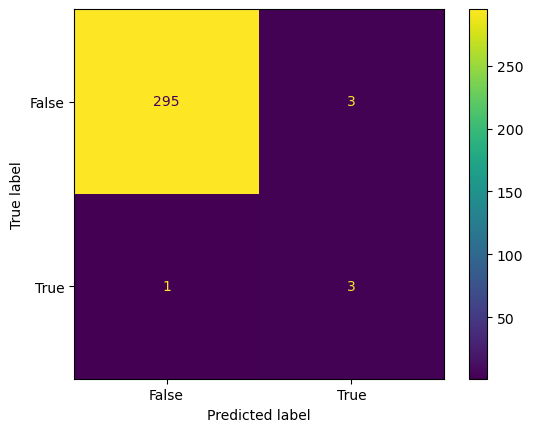

 
Train results:
1.0


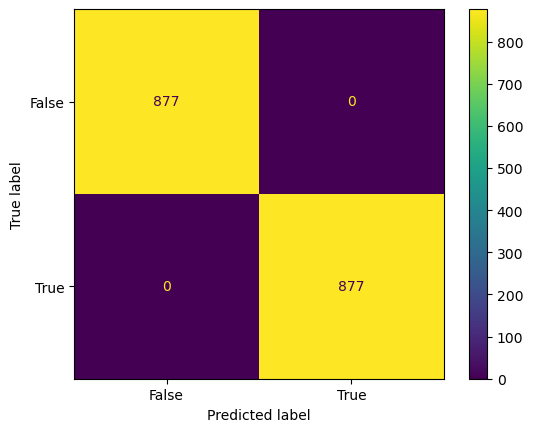

0.6

In [261]:
from sklearn.ensemble import RandomForestClassifier

Train_fit_Validate_model(X_train_o,y_train_o,X_test,y_test,RandomForestClassifier(max_features=300, min_samples_leaf=3,n_estimators=400),plot=True)

# 4-fold cross validation RF
Best parameters: {'max_features': 300, 'min_samples_leaf': 3, 'n_estimators': 400}

Test Results:
0.75


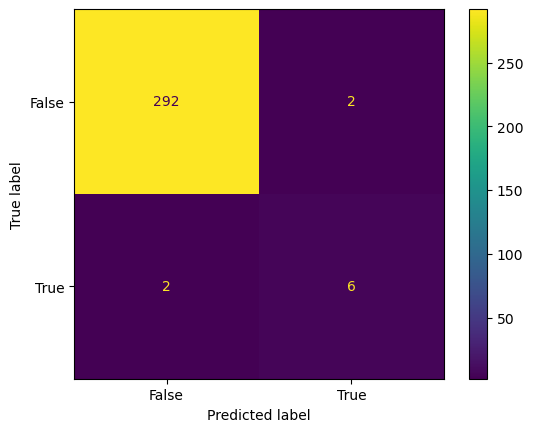

 
Train results:
0.9994327850255247


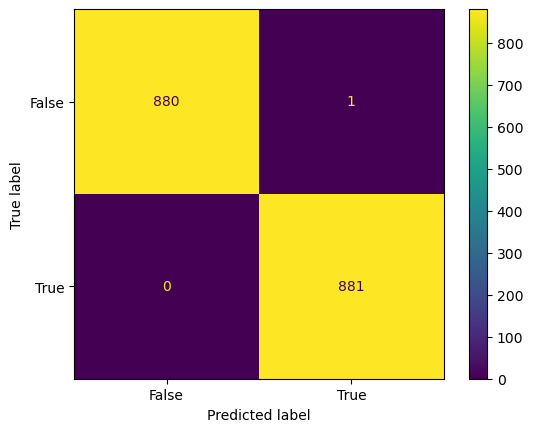

Test Results:
0.7692307692307692


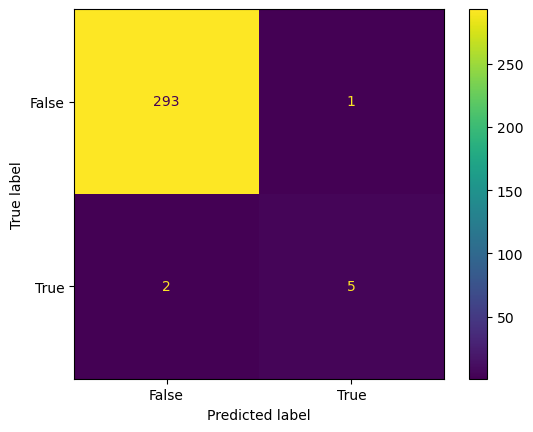

 
Train results:
1.0


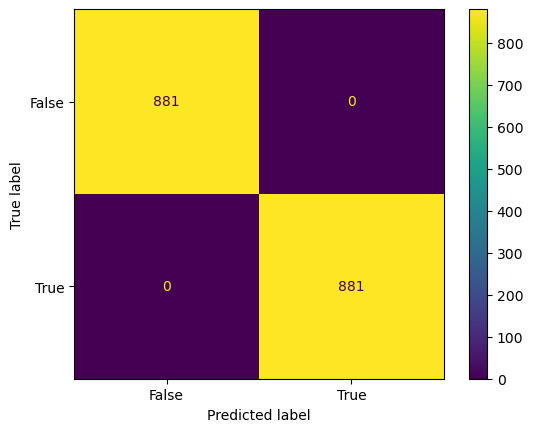

Test Results:
0.6153846153846153


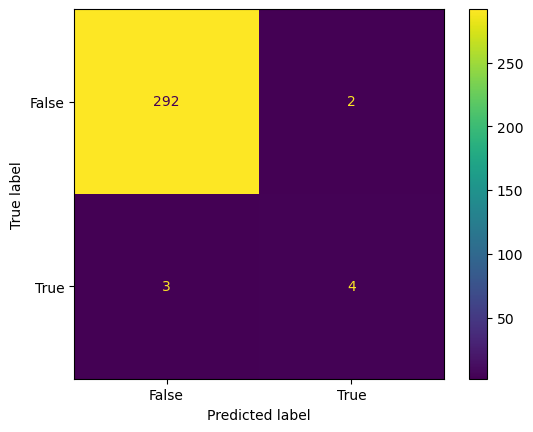

 
Train results:
0.9994327850255247


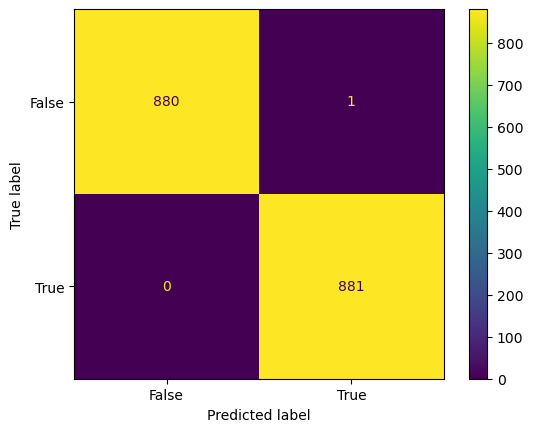

Test Results:
0.8571428571428571


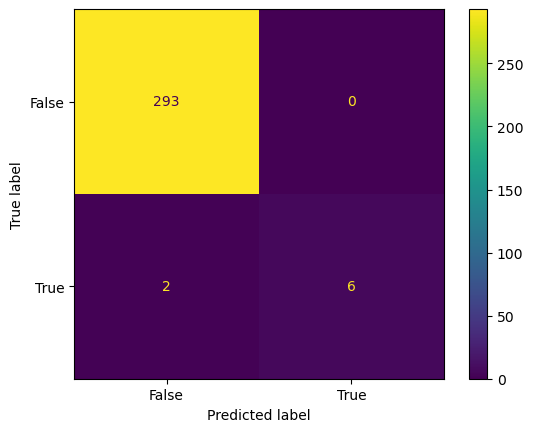

 
Train results:
1.0


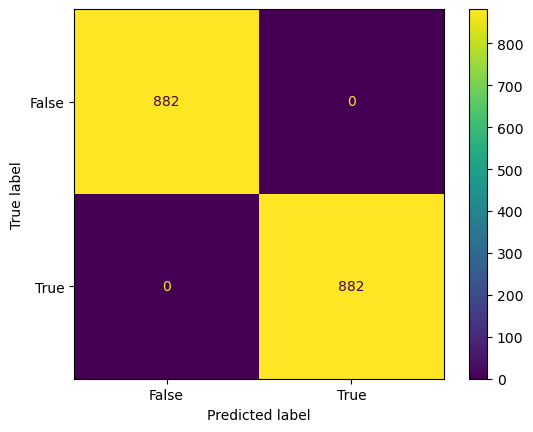

0.7479395604395604


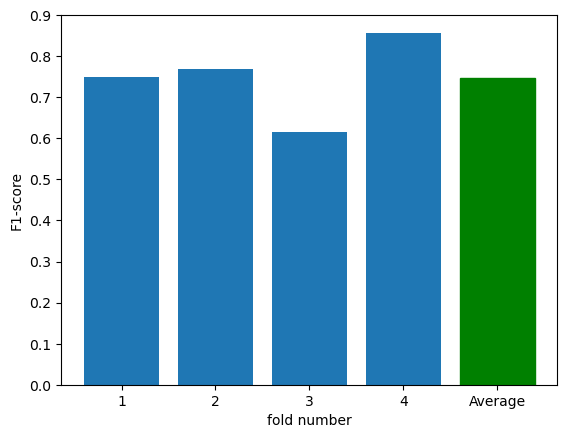

In [262]:
Test_peformance= train_and_test_kfold(X,y,model=RandomForestClassifier(max_features=300, min_samples_leaf=3,n_estimators=400),n_splits=4,plot=1)
print(np.mean(Test_peformance))

plot=Test_peformance.copy()
plot.append(np.mean(plot))

bar=plt.bar(['1','2','3','4','Average'],plot)
plt.ylabel('F1-score')
plt.xlabel('fold number')
bar[4].set_color('g')

## Repeat 4-fold 30 times for average peformance

In [263]:
import xgboost as xgb

lst=[]
for i in range(30):
   Test_peformance = train_and_test_kfold(X,y,model=RandomForestClassifier(max_features=300, min_samples_leaf=3,n_estimators=400),n_splits=4,plot=0)
   lst.append(Test_peformance)

print(np.mean(lst))
print(np.std(lst))

0.7017356139589112
0.14186288531614752


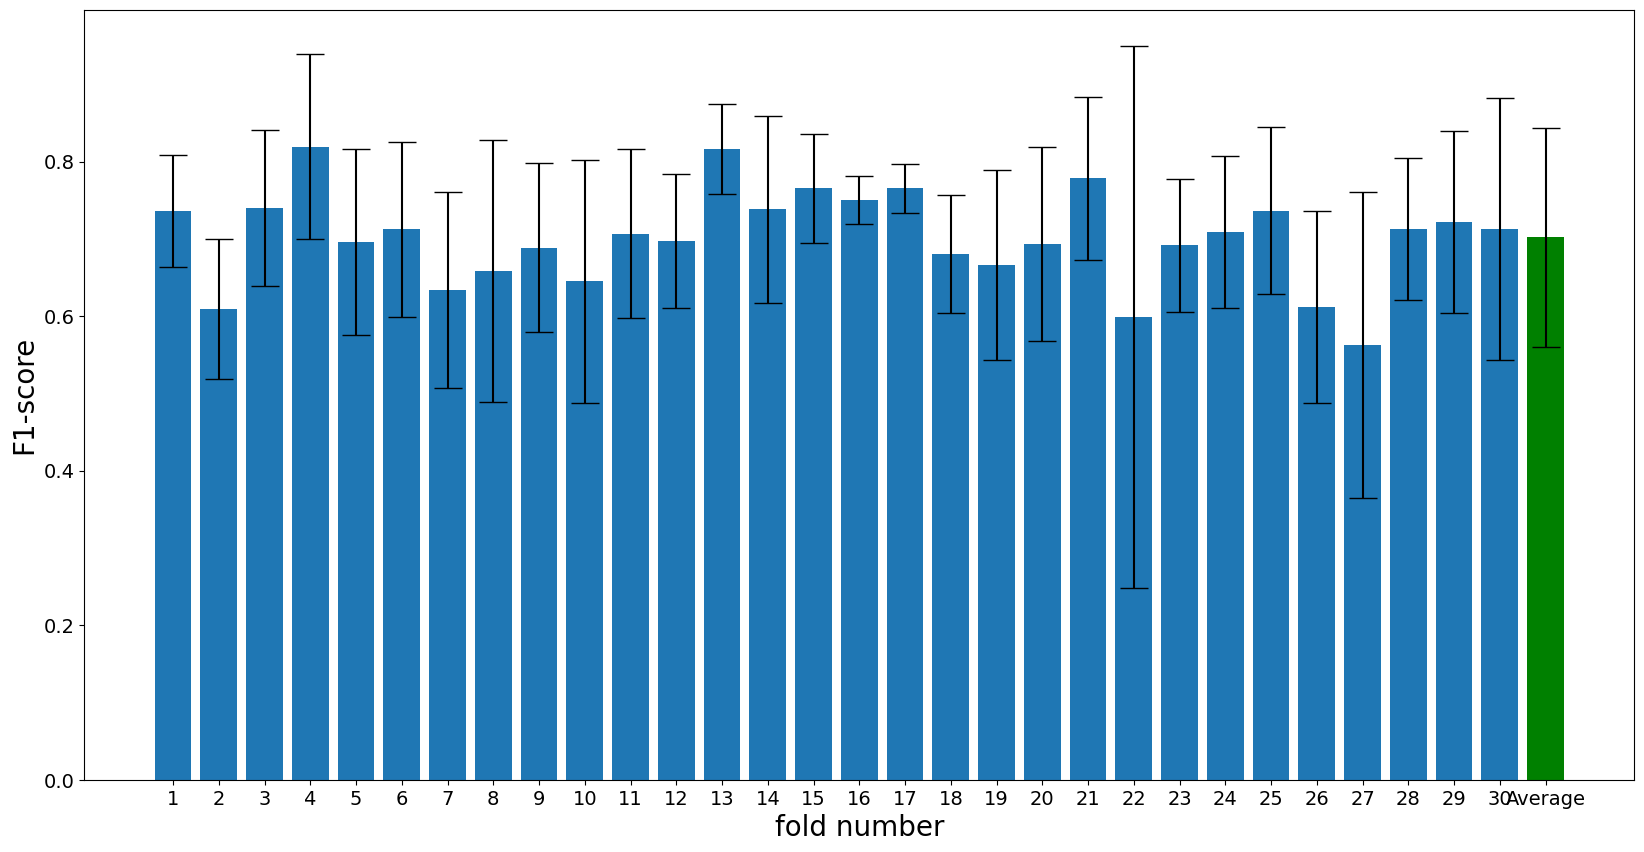

In [264]:
another_list_mean=[]
another_list_std=[]
for sub_lst in lst:
    another_list_mean.append(np.mean(sub_lst))
    another_list_std.append(np.std(sub_lst))

plot=another_list_mean.copy()
plot.append(np.mean(another_list_mean))

err=another_list_std.copy()
err.append(np.std(lst))

fig, ax = plt.subplots(figsize=(20,10))

colors = ['#1f77b4'] * 31
colors[30] = 'green'

ax.bar(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','Average'],plot,yerr=err,capsize=10,color=colors)
ax.set_ylabel('F1-score',fontsize=20)
ax.set_xlabel('fold number',fontsize=20)
ax.tick_params(axis='both', labelsize=14)

## Optimising RF Hyperparamters

In [265]:
# from sklearn.model_selection import GridSearchCV

# params = { 'max_features': [100,300,500,800],
#           'min_samples_leaf': [1,3,5,7],
#           'n_estimators': [300,400,500,700,1000],}
# xgbr = RandomForestClassifier()
# clf = GridSearchCV(estimator=xgbr, 
#                   param_grid=params,
#                   scoring='f1')
# clf.fit(X, y)
# print("Best parameters:", clf.best_params_)

# Final model fit

In [267]:
from imblearn.over_sampling import SMOTE
from joblib import dump


oversample = SMOTE()
X_o, y_o = oversample.fit_resample(X, y)

model=RandomForestClassifier(max_features=300, min_samples_leaf=3,n_estimators=400)
model.fit(X_o,y_o)



dump(model,os.getcwd()+'\\temp folder\\check_valve_model.joblib') 

['check_valve_model.joblib']

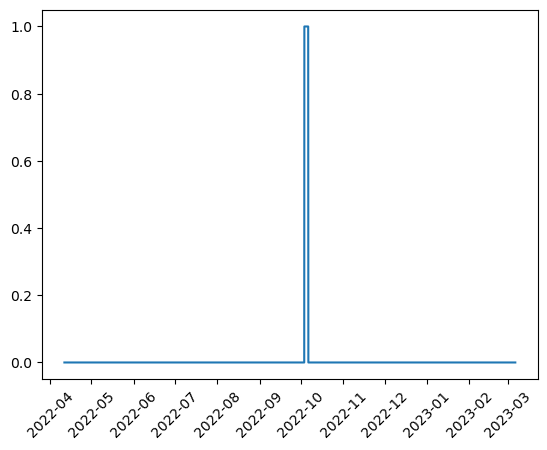

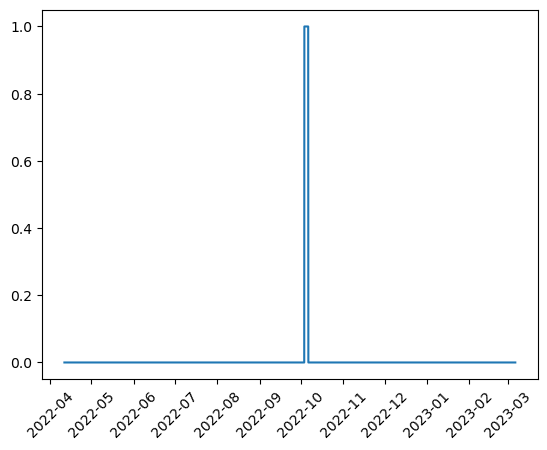

In [270]:
import datetime
y_all=model.predict(X)

y_all=pd.Series(y_all)

predictions_dated=pd.concat([y_dated,y_all],axis=1)

plt.plot(y_dated[0],y_dated['contains_search_string'])
plt.tick_params(axis='x', labelrotation=45)
#plt.xlim([datetime.date(2022,9,1),datetime.date(2022,10,30)])
plt.figure()




plt.plot(y_dated[0],y_all)
plt.tick_params(axis='x', labelrotation=45)
#plt.xlim([datetime.date(2022,9,1),datetime.date(2022,10,30)])


# Update Production Model
**Only run when you know what your doing**\
This cell will take the model that has been trained above and move it from the temp folder to the model for deployment.\
Thus, if you are fooling around and your model sucks if you run this cell you implement the new, bad model.
Be very carefull 

In [ ]:
from datetime import date
import shutil
from pathlib import Path


user = os.getlogin()
curr_date = str(date.today())
comment = "First deployment version"
version = 'V2'

lines = [user,'\n',curr_date,'\n',comment,'\n',version]
with open(os.getcwd()+'\\temp folder\\model_meta_data.txt', 'w') as f:
    f.writelines(lines)


meta_data_path = os.getcwd()+'\\temp folder\\model_meta_data.txt'
model_path = os.getcwd()+'\\temp folder\\membrane_guess_model.json'
norm_value_path=os.getcwd()+'\\temp folder\\normalisation_values.csv'

def getParentDir(path, level=1):
  return os.path.normpath( os.path.join(path, *([".."] * level)) )

upper_folder=getParentDir(os.getcwd(),level=2)

meta_dest = upper_folder + "\\Model for Deployment\\Check_Ball_Model\\Dependencies\\model_meta_data.txt"
model_dest = upper_folder + "\\Model for Deployment\\Check_Ball_Model\\Dependencies\\check_valve_model.joblib'"
norm_dest = upper_folder + "\\Model for Deployment\\Check_Ball_Model\\Dependencies\\normalisation_values.csv"

shutil.move(meta_data_path, meta_dest)
shutil.move(model_path,model_dest)
shutil.move(norm_value_path,norm_dest)
